In [63]:
from utils import convert_rule4paper
%load_ext autoreload
%autoreload 2

import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import display

import data_config
from data.movielens_data import MovielensData
from elections import InstacartDataFrames
from elections_raw import PrefProfile
from electionutils import ElectionUtils
from experiments.calibration import summarise_all_flavours
from notebooks import distance_utils
from sql_database import Database
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# COMMITTEE SPREAD P2P ANALYSIS

df = pd.read_csv("../out/prod/committee_spread/p2p-diversities.csv")

df1 = pd.read_csv("../out/prod/committee_spread/algo_quality_basic1k_winners.csv.zip")

dfs = {
    k: df.query(f"search_approvals > {bounds[0]} and search_approvals <= {bounds[1]} and algo == 'Greedy' ")
     .sort_values('p2p_diversity')[['rule', 'p2p_diversity']]
     .groupby('rule').agg('mean')
      for k, bounds in dict(
        _100=(0, 100),
        _1000=(100, 1000),
        _10000=(1000, 10000),
        _100000=(10000, 100000),
    ).items()}

for k, _df in dfs.items():
    _df.columns=[k]
df2 = pd.concat(dfs.values(), axis = 1)
df2

with open("../out/prod/committee_spread/p2p-diversities-average.tex", 'w') as f:
    for x in df2.itertuples():
        text = f"{convert_rule4paper(x.Index)}\t&\t{x._1:.2f}\t&\t{x._2:.2f}\t&\t{x._3:.2f}\t&\t{x._4:.2f} \\\\ \n"
        f.write(text)
        print(text)
print("saved average diversities to .tex file")



$1$-HUV	&	90675.69	&	62842.10	&	5834.14	&	348.79 \\ 

$2$-HUV	&	94900.90	&	73698.52	&	12534.00	&	901.42 \\ 

$3$-HUV	&	95703.85	&	77897.99	&	16534.65	&	1312.64 \\ 

saved average diversities to .tex file


In [ ]:
# FIND THE COUNTING RRADIUS APPROVAL RATIOS

df_fig = pd.read_csv("../out/prod/counting_rradius_raw/generated_p/counting_rradius_raw.csv.zip", compression='zip')

phi_extractor = lambda profile_key: profile_key.split("phi=")[1] if "phi=" in profile_key else "None"
df_fig['phi'] = df_fig[['profile_key']].apply(lambda x: phi_extractor(*x), axis=1)

p_extractor = lambda profile_key: float(profile_key.split("p=")[1].split('-')[0] if "p=" in profile_key else None)
df_fig['p'] = df_fig[['profile_key']].apply(lambda x: p_extractor(*x), axis=1)

row_header = lambda perturbation_type: f"{perturbation_type}"
df_fig['perturbation_type'] = df_fig[['perturbation_type']].apply(lambda x: row_header(*x), axis=1)

df_fig['perturbations (%)'] = df_fig.perturbation_level * 100
df_fig['elections changed (%)'] = df_fig.changed * 100

print(df_fig.profile_key.values[0])
df_fig

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

# Simulate data from a bivariate Gaussian
# n = 10000
# mean = [0, 0]
# cov = [(2, .4), (.4, .2)]
# rng = np.random.RandomState(0)
# x, y = rng.multivariate_normal(mean, cov, n).T

# Draw a combo histogram and scatterplot with density contours
# f, ax = plt.subplots(figsize=(6, 6))
# x = df_fig['perturbations (%)']
# y = df_fig['p']
# z = df_fig["elections changed (%)"]
# sns.scatterplot(data=df_fig, x=x, y=y, s=5, c=z)
# sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako", hue=z)
# sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

df_fig.query("phi=='0.5' and perturbation_type=='ADD' and rule=='$1$-HUV'").pivot(index='p', columns='perturbations (%)', values="elections changed (%)")
# df_fig['perturbations (%)'].unique()
# df_fig2 = pd.read_csv("../out/prod/counting_rradius_raw/generated/counting_rradius_raw.csv.zip", compression='zip')
# df_fig2.profile_key.unique()
# gen_profile_funcs=[
#     eval(f"lambda: PrefProfile.generate_mapel(n_resources=100, n_agents=100, model_id='approval_resampling', phi={phi}, p={p})")
#     for phi in [0.25, .5, .75, 1.0] for p in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
# ]
# [x().name for x in gen_profile_funcs]

NameError: name 'df_fig' is not defined

In [183]:
# FIND THE COUNTING RRADIUS APPROVAL RATIOS

pref_folder = '../out/prod/counting_rradius_raw/movielens/movielens_profiles'
stats = []
for filename in os.listdir(pref_folder):
    pp = PrefProfile.from_file(f"{pref_folder}/{filename}")
    approvals_per_voter = sum(map(lambda x: len(x) / pp.n_agents, pp.preferences))
    approval_ratio = approvals_per_voter / pp.n_resources

    approval_ratio_per_voter = list(map(lambda x: len(x) / pp.n_resources, pp.preferences))
    avg_aratio = np.mean(approval_ratio_per_voter)
    std_aratio = np.std(approval_ratio_per_voter)

    stats.append(dict(filename=filename,
                      avg_approvals_per_voter=approvals_per_voter,
                      approval_ratio=approval_ratio,
                      avg_aratio=avg_aratio,
                      std_aratio=std_aratio))

pd.DataFrame(stats)

filename  avg_approvals_per_voter  \
0       Star Trek V: The Final Frontier .1989.                 5.258427   
1  Indiana Jones and the Temple of Doom .1984.                 5.259740   
2                            Hot Shots! .1991.                 8.193878   
3   Star Trek III: The Search for Spock .1984.                 5.289157   

   approval_ratio  avg_aratio  std_aratio  
0        0.052584    0.052584    0.062899  
1        0.052597    0.052597    0.050796  
2        0.081939    0.081939    0.057635  
3        0.052892    0.052892    0.061380

In [5]:
# PLOT THE QUALITY FACTOR

import seaborn as sns

df = pd.DataFrame(list(range(1, 26)), columns=['i'])
df['quality factor'] = df.i.apply(lambda i: -math.atan((i - 13) / 10) + 2)
sns.set_theme\
    (palette='bright', style='white', context='talk')
f = sns.relplot(kind='line', data=df, x='i', y='quality factor', aspect=2
                )
f.savefig("../out/prod/quality-factor.png", dpi=300)

In [ ]:

# ===================================================================
# BUILD THE REFERENCE TABLES - MOVIELENS AND GOODBOOKS

def load_dataset(
        dataset,
        min_popularity  # only movies with at least
):
    idata = MovielensData(dataset)
    dataset_iframes = InstacartDataFrames.from_data(idata, min_popularity=min_popularity)
    dataset_utils = ElectionUtils(dataset_iframes, db_filename=":memory:")
    return idata, dataset_iframes, dataset_utils


id, iframes, ut = load_dataset(dataset=data_config.data_movielens_25m, min_popularity=20)

# ===================================================================
# CALIBRATION

summarise_all_flavours('../out/prod/calibration_gr')
summarise_all_flavours('../out/prod/calibration')

reading instacart data
reading DataFrame order_products__all from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/order_products__all.parquet
order_products__all contains 4122111 items
WARN: Only products with min_popularity=20 considered (69 approvals filtered from 4122111 to 4122042)
reading DataFrame orders from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/orders.parquet
orders contains 53406 items
reading DataFrame products from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/products.parquet
products contains 10000 items
reading DataFrame departments from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/departments.parquet
departments contains 1 items
reading DataFrame aisles from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/aisles.parquet
aisles contains 1 items
creating db with 10000 products
../out/prod/distances-goodreads/mixed
../out/prod/distances-goodreads/anne


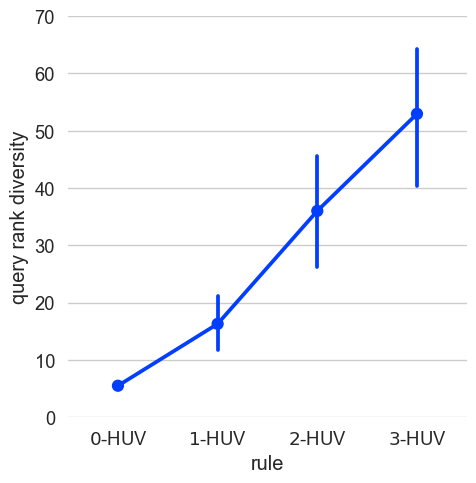

In [143]:
# ===================================================================
# distance maps
dataset = data_config.data_movielens_25m
min_popularity = 20  # only movies with at least
idata = MovielensData(dataset)
dataset_iframes = InstacartDataFrames.from_data(idata, min_popularity=min_popularity)
dataset_utils = ElectionUtils(dataset_iframes, db_filename=":memory:")

for exp_folder in [
    "../out/prod/distances-movielens",
]:
    for folder in os.listdir(exp_folder):
        if folder[0] != '.' and ('anne' in folder or 'mixed' in folder):
            print(f"{exp_folder}/{folder}")
            distance_utils.visualise_diversity(f"{exp_folder}/{folder}", dataset_utils,
                                               ylim=(0, 70))

% \begin{tabular}{rrrrrrrrrrr} 
% \toprule 
% title & agents & g0 & g1 & g2 & g3 & g3a & g4 & sa0 & sa1 & sa2\\ 

            % \midrule
            Star Trek: Renegades & 13 & 1 & 1.10 & 1.13 & 1.19 & 1.24 & 1.26 & 1 & 1.12 & 1.20 \\
Captain Marvel & 236 & 26 & 4.56 & 5.40 & 6.91 & 8.14 & 8.70 & 8 & 2.46 & 2.73 \\
Ant-Man and the Wasp & 399 & 47 & 5.44 & 6.45 & 8.35 & 10.03 & 10.66 & 13 & 2.54 & 3.06 \\
Star Trek V: The Final Frontier & 703 & 79 & 7.60 & 8.99 & 11.09 & 12.68 & 13.57 & 21 & 3.24 & 3.72 \\
Star Trek III: The Search for Spock & 1452 & 203 & 9.35 & 11.21 & 13.67 & 16.05 & 17.67 & 44 & 3.28 & 3.81 \\
            
            
            % \bottomrule
            % \end{tabular}
            % \caption{\label{tab:algo_perf}}
                    


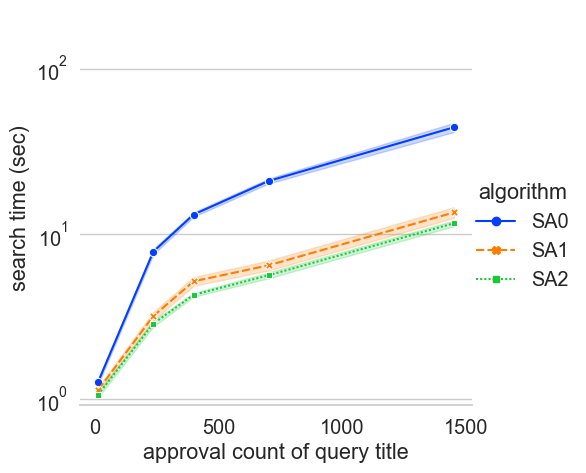

In [144]:

# ===================================================================
# ALGO_PERFORMANCE

from experiments.algo_performance import algo_performance_postprocess
# from IPython import display
import seaborn as sns

# target, flavour = 'prod', 'ilp'
target, flavour = 'prod', 'basic'
out_folder = f"../out/{target}/algo_performance/{flavour}"
algo_performance_postprocess('prod', 'basic', out_folder=out_folder)
with open(f"{out_folder}/aperf-speedup-table.tex", 'r') as f:
    print(f.read())


In [145]:
target, flavour = 'prod', 'classic'
db = Database(f"../out/{target}/distances-movielens/{flavour}/cache.db")
df = db.query(f"""
    select *
    from winners w inner join p2p_ranks r on w.search_product_id=r.id1 and w.product_id=id2
    """)
df
# sns.catplot(data=df, kind='point', x='rule', y='avg_rank', hue='search_term', ci=95, dodge=0.2)

run_name  steps    idf  product_id  \
0   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        3869   
1   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1         466   
2   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        3868   
3   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        5500   
4   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        3208   
..                                           ...    ...    ...         ...   
73  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        2476   
74  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        1262   
75  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        2476   
76  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        1262   
77  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        2476   

                                         product_name   rule  rulex algo  \
0      Naked Gun 2 1/2: The Smell of Fear, The (1991)  HUV_0  HUV_0    g   
1                         Hot Shots! Part Deux (1993)  HUV_0  HUV_0    g   
2   Naked Gun: From the Files of Police Squad!, Th...  HUV_0  HUV_0    g   
3                                  Top Secret! (1984)  HUV_0  HUV_0    g   
4   Loaded Weapon 1 (National Lampoon's Loaded Wea...  HUV_0  HUV_0    g   
..                                                ...    ...    ...  ...   
73                            Heartbreak Ridge (1986)  HUV_1  HUV_1    g   
74                           Great Escape, The (1963)  HUV_2  HUV_2    g   
75                            Heartbreak Ridge (1986)  HUV_2  HUV_2    g   
76                           Great Escape, The (1963)  HUV_3  HUV_3    g   
77                            Heartbreak Ridge (1986)  HUV_3  HUV_3    g   

    algo_version  rank                search_term  search_product_id   id1  \
0              4     1        ^Hot Shots! .1991.$               5541  5541   
1              4     2        ^Hot Shots! .1991.$               5541  5541   
2              4     3        ^Hot Shots! .1991.$               5541  5541   
3              4     4        ^Hot Shots! .1991.$               5541  5541   
4              4     5        ^Hot Shots! .1991.$               5541  5541   
..           ...   ...                        ...                ...   ...   
73             4     8  ^Dirty Dozen, The .1967.$               2944  2944   
74             4     2  ^Dirty Dozen, The .1967.$               2944  2944   
75             4     7  ^Dirty Dozen, The .1967.$               2944  2944   
76             4     2  ^Dirty Dozen, The .1967.$               2944  2944   
77             4     5  ^Dirty Dozen, The .1967.$               2944  2944   

     id2  rank_1_2  rank_2_1  avg_rank  
0   3869         2         1       1.5  
1    466         1         2       1.5  
2   3868         2         3       2.5  
3   5500         2         4       3.0  
4   3208         2         5       3.5  
..   ...       ...       ...       ...  
73  2476         6        50      28.0  
74  1262         2         4       3.0  
75  2476         6        50      28.0  
76  1262         2         4       3.0  
77  2476         6        50      28.0  

[78 rows x 17 columns]

In [43]:
dist_flavours = ['classic', 'jamesbond', 'indiana-all', 'marvel', 'star-trek-all', 'star-wars-all']
target = 'prod'
db = {flavour: Database(f"../out/{target}/distances-movielens/{flavour}/cache.db") for flavour in dist_flavours}

In [74]:
pids_sql = "select product_id from winners where search_product_id = 1373 and rule=='HUV_3'"
db['classic'].query(f"WITH pids as ({pids_sql}) "
                    f"  select * from p2p_ranks "
                    f"  where "
                    f"      (id1 = 1373 and id2 in pids) or"
                    f"      (id2 = 1373 and id1 in pids) "
                    f"  order by id1")

id1   id2  rank_1_2  rank_2_1  avg_rank
0    1373  1371         2         2       2.0
1    1375  1373         1         4       2.5
2    2408  1373        18        21      19.5
3    2531  1373        13        24      18.5
4    2615  1373        41        82      61.5
5    2643  1373        48        27      37.5
6    5211  1373       557       586     571.5
7    5596  1373       466      1013     739.5
8    5944  1373         6         2       4.0
9  141402  1373       454       200     327.0

In [76]:
db['classic'].query(f"WITH pids as ({pids_sql}) "
                    f"  select count(*) from p2p_ranks "
                    f"  where "
                    f"      (id1 in pids) and"
                    f"      (id2 in pids) "
                    f"  order by id1")

count(*)
0        39

In [10]:
def show_winners_match_counts(dbs, dist_flavours):
    for flavour in dist_flavours:
        df = dbs[flavour].query(f"""
            select rule, search_term, count(*) as count
            from winners w inner join p2p_ranks r
            where (
                w.search_product_id=r.id1 and w.product_id=id2 or
                w.search_product_id=r.id2 and w.product_id=id1
            )
            group by search_term, rule
            """)
        sns.catplot(data=df, kind='point', x='rule', y='count', hue='search_term', ci=95, dodge=0.2)


def analyse_classic(db):
    # df = db.query("select search_product_id, count(*) from dist_metric group by search_product_id")
    # display(df)
    # Frontier = 1373
    show = lambda sql: display(db.query(sql))
    show("select * from winners where search_term like '%Frontier%' and rule=='HUV_3'")
    # pids_sql = "select product_id from winners where search_product_id =1373 and rule=='HUV_3'"
    # show(pids_sql)
    # show(f"select * from dist_metric where search_product_id = 1373 and product_id in ({pids_sql})")
    # show(f"select * from dist_metric where product_id = 1373 and search_product_id in ({pids_sql})")
    # show(f"select * from p2p_ranks where id1 = 1373 and id2 in ({pids_sql}) order by id1")
    # show(f"select * from p2p_ranks where id2 = 1373 and id1 in ({pids_sql}) order by id1")
    # show(f' select a.product_id as id1, b.product_id as id2, '
    #      '      a.rank rank_1_2, b.rank rank_2_1, (a.rank+b.rank)/2.0 avg_rank'
    #      ' from dist_metric a '
    #      ' inner join dist_metric b on '
    #      '      a.search_product_id < a.product_id and'
    #      '      a.search_product_id = b.product_id and b.search_product_id = a.product_id'
    #      # '      and a.search_product_id = 1373 and a.product_id = 1375'
    #      f'      and ('
    #      f'         (a.search_product_id = 1373 and a.product_id in ({pids_sql})) or '
    #      f'         (b.search_product_id = 1373 and b.product_id in ({pids_sql})) '
    #      f'         )'
    #      )

# show_winners_match_counts(db, dist_flavours)
# analyse_classic(db['classic'])

['/Users/gregaw/code/ddr/esearch/es', '/Users/gregaw/code/ddr/esearch/es', '/Users/gregaw/code/ddr/esearch/notebooks', '/Users/gregaw/code/ddr/esearch', '/Users/gregaw/code/ddr/esearch/tests', '/Users/gregaw/code/ddr/esearch/es', '/Users/gregaw/Anaconda/anaconda3/envs/esearch/lib/python37.zip', '/Users/gregaw/Anaconda/anaconda3/envs/esearch/lib/python3.7', '/Users/gregaw/Anaconda/anaconda3/envs/esearch/lib/python3.7/lib-dynload', '', '/Users/gregaw/Anaconda/anaconda3/envs/esearch/lib/python3.7/site-packages', '/Users/gregaw/Anaconda/anaconda3/envs/esearch/lib/python3.7/site-packages/IPython/extensions', '/Users/gregaw/.ipython', '/Users/gregaw/Library/Application Support/JetBrains/IntelliJIdea2021.1/plugins/python/helpers/pydev', '/Users/gregaw/Library/Application Support/JetBrains/IntelliJIdea2021.1/plugins/python/helpers-pro/jupyter_debug']


/Users/gregaw/Anaconda/anaconda3/envs/esearch/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 100 + 1) instead
  
/Users/gregaw/Anaconda/anaconda3/envs/esearch/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 100 + 1) instead
  if __name__ == "__main__":
/Users/gregaw/Anaconda/anaconda3/envs/esearch/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 5 + 1) instead
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:xlabel='x', ylabel='y'>

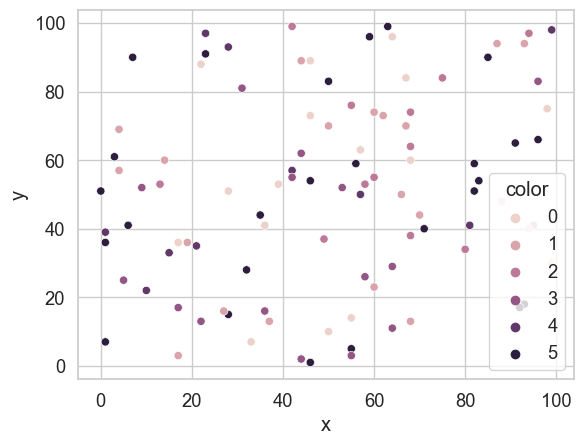

In [43]:
import seaborn as sns
import numpy as np
import pandas as pd

n = 100
cols = 6

df = pd.DataFrame(dict(x=np.random.random_integers(0, 100, n),
                       y=np.random.random_integers(0, 100, n),
                       color=np.random.random_integers(0, cols - 1, n)
                       ))
pal = sns.cubehelix_palette(n_colors=cols)
display(sns.scatterplot(data=df, x=df.x, y=df.y, hue=df.color, palette=[c for c in pal]))

In [60]:
pal = sns.hls_palette(n_colors=cols)
pal = sns.color_palette('bright', n_colors=6)
display(sns.scatterplot(data=df, x=df.x, y=df.y, hue=df.color, palette=[c for c in pal]))


<AxesSubplot:xlabel='x', ylabel='y'>

In [59]:
# display(sns.scatterplot(data=df, x=df.x, y=df.y, hue=df.color, palette=[c for c in pal]))
# repeated_colors([2,1])
pal = sns.color_palette('bright', n_colors=6)
pal

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0)]